In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn import feature_extraction, linear_model, model_selection, preprocessing
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline

In [2]:

fake = pd.read_csv("data/Fake.csv")
true = pd.read_csv("data/True.csv")

In [3]:
fake.shape

(23481, 4)

In [4]:

true.shape

(21417, 4)

In [5]:
#Data cleaning and preparation :

In [6]:
# Add flag to track fake and real
fake['target'] = 'fake'
true['target'] = 'true'

In [7]:
# Concatenate dataframes
data = pd.concat([fake, true]).reset_index(drop = True)
data.shape

(44898, 5)

In [8]:
# Shuffle the data
from sklearn.utils import shuffle
data = shuffle(data)
data = data.reset_index(drop=True)

In [9]:
# Check the data
data.head()

,title,text,subject,date,target
0,Iraqi forces breach Islamic State stronghold T...,BAGHDAD (Reuters) - Iraqi forces breached on T...,politicsNews,"August 22, 2017",true
1,"House, Senate Republicans face challenge over ...",WASHINGTON (Reuters) - U.S. Republicans in Con...,politicsNews,"December 5, 2017",true
2,Retirement plan offered by Trump pick Puzder s...,WASHINGTON (Reuters) - Fast food executive And...,politicsNews,"December 9, 2016",true
3,‘Lock Him Up!’ Passengers Chant To Disruptive...,A passenger wearing a Make America Great Agai...,News,"May 22, 2017",fake
4,HILLARY EPICALLY BOMBS PRESS CONFERENCE About ...,Hillary Clinton is known world-wide for saying...,Government News,"Sep 19, 2016",fake


In [10]:
# Removing the date (we won't use it for the analysis)
data.drop(["date"],axis=1,inplace=True)
data.head()

,title,text,subject,target
0,Iraqi forces breach Islamic State stronghold T...,BAGHDAD (Reuters) - Iraqi forces breached on T...,politicsNews,true
1,"House, Senate Republicans face challenge over ...",WASHINGTON (Reuters) - U.S. Republicans in Con...,politicsNews,true
2,Retirement plan offered by Trump pick Puzder s...,WASHINGTON (Reuters) - Fast food executive And...,politicsNews,true
3,‘Lock Him Up!’ Passengers Chant To Disruptive...,A passenger wearing a Make America Great Agai...,News,fake
4,HILLARY EPICALLY BOMBS PRESS CONFERENCE About ...,Hillary Clinton is known world-wide for saying...,Government News,fake


In [11]:
# Removing the title (we will only use the text)
data.drop(["title"],axis=1,inplace=True)
data.head()

,text,subject,target
0,BAGHDAD (Reuters) - Iraqi forces breached on T...,politicsNews,true
1,WASHINGTON (Reuters) - U.S. Republicans in Con...,politicsNews,true
2,WASHINGTON (Reuters) - Fast food executive And...,politicsNews,true
3,A passenger wearing a Make America Great Agai...,News,fake
4,Hillary Clinton is known world-wide for saying...,Government News,fake


In [12]:
# Convert to lowercase

data['text'] = data['text'].apply(lambda x: x.lower())
data.head()

,text,subject,target
0,baghdad (reuters) - iraqi forces breached on t...,politicsNews,true
1,washington (reuters) - u.s. republicans in con...,politicsNews,true
2,washington (reuters) - fast food executive and...,politicsNews,true
3,a passenger wearing a make america great agai...,News,fake
4,hillary clinton is known world-wide for saying...,Government News,fake


In [13]:
# Remove punctuation

import string

def punctuation_removal(text):
    all_list = [char for char in text if char not in string.punctuation]
    clean_str = ''.join(all_list)
    return clean_str

data['text'] = data['text'].apply(punctuation_removal)

In [14]:
# Check
data.head()

,text,subject,target
0,baghdad reuters iraqi forces breached on tues...,politicsNews,true
1,washington reuters us republicans in congress...,politicsNews,true
2,washington reuters fast food executive andy p...,politicsNews,true
3,a passenger wearing a make america great agai...,News,fake
4,hillary clinton is known worldwide for saying ...,Government News,fake


In [15]:
# Removing stopwords
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop = stopwords.words('english')

data['text'] = data['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/alatrech/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [16]:
data.head()

,text,subject,target
0,baghdad reuters iraqi forces breached tuesday ...,politicsNews,true
1,washington reuters us republicans congress gra...,politicsNews,true
2,washington reuters fast food executive andy pu...,politicsNews,true
3,passenger wearing make america great hat suppo...,News,fake
4,hillary clinton known worldwide saying ridicul...,Government News,fake


In [17]:
#Basic data exploration

subject
Government News     1570
Middle-east          778
News                9050
US_News              783
left-news           4459
politics            6841
politicsNews       11272
worldnews          10145
Name: text, dtype: int64


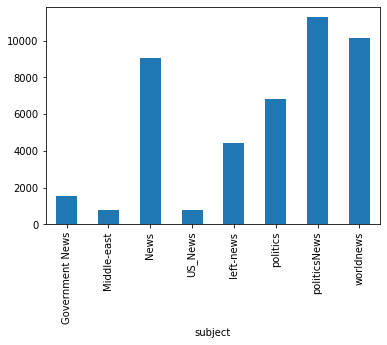

In [18]:
# How many articles per subject?
print(data.groupby(['subject'])['text'].count())
data.groupby(['subject'])['text'].count().plot(kind="bar")
plt.show()

target
fake    23481
true    21417
Name: text, dtype: int64


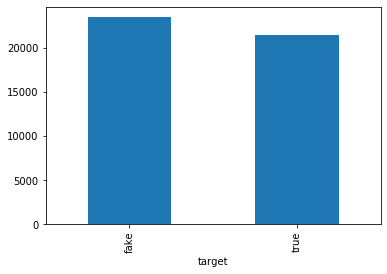

In [19]:

# How many fake and real articles?
print(data.groupby(['target'])['text'].count())
data.groupby(['target'])['text'].count().plot(kind="bar")
plt.show()

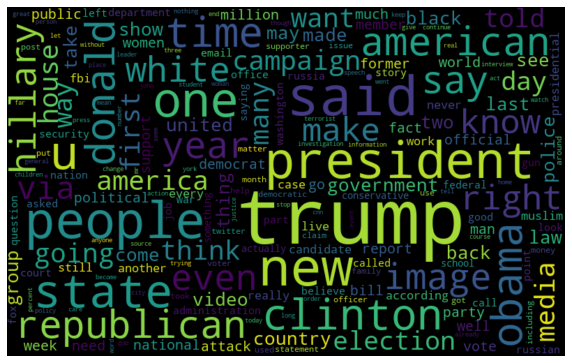

In [20]:

# Word cloud for fake news
from wordcloud import WordCloud

fake_data = data[data["target"] == "fake"]
all_words = ' '.join([text for text in fake_data.text])

wordcloud = WordCloud(width= 800, height= 500,
                          max_font_size = 110,
                          collocations = False).generate(all_words)

plt.figure(figsize=(10,7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

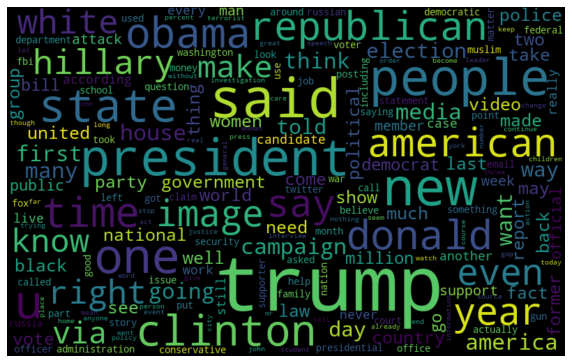

In [21]:

# Word cloud for real news
from wordcloud import WordCloud

real_data = data[data["target"] == "true"]
all_words = ' '.join([text for text in fake_data.text])

wordcloud = WordCloud(width= 800, height= 500,
                          max_font_size = 110,
                          collocations = False).generate(all_words)

plt.figure(figsize=(10,7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [22]:
# Most frequent words counter (Code adapted from https://www.kaggle.com/rodolfoluna/fake-news-detector)   
from nltk import tokenize

token_space = tokenize.WhitespaceTokenizer()

def counter(text, column_text, quantity):
    all_words = ' '.join([text for text in text[column_text]])
    token_phrase = token_space.tokenize(all_words)
    frequency = nltk.FreqDist(token_phrase)
    df_frequency = pd.DataFrame({"Word": list(frequency.keys()),
                                   "Frequency": list(frequency.values())})
    df_frequency = df_frequency.nlargest(columns = "Frequency", n = quantity)
    plt.figure(figsize=(12,8))
    ax = sns.barplot(data = df_frequency, x = "Word", y = "Frequency", color = 'blue')
    ax.set(ylabel = "Count")
    plt.xticks(rotation='vertical')
    plt.show()

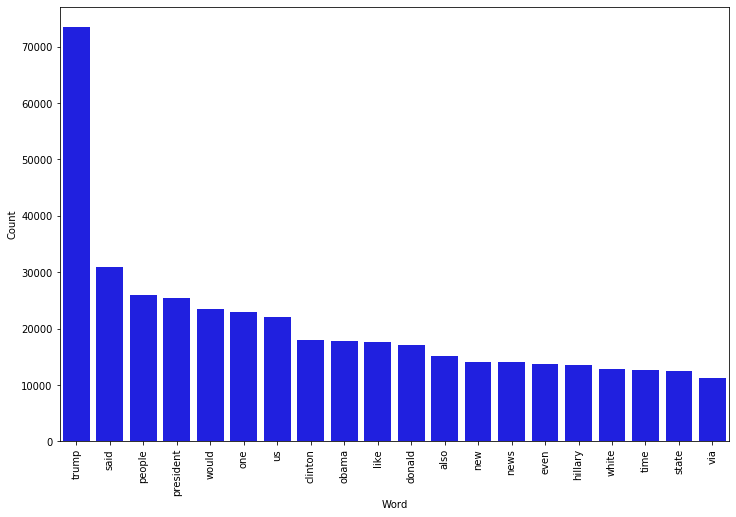

In [23]:
# Most frequent words in fake news
counter(data[data["target"] == "fake"], "text", 20)

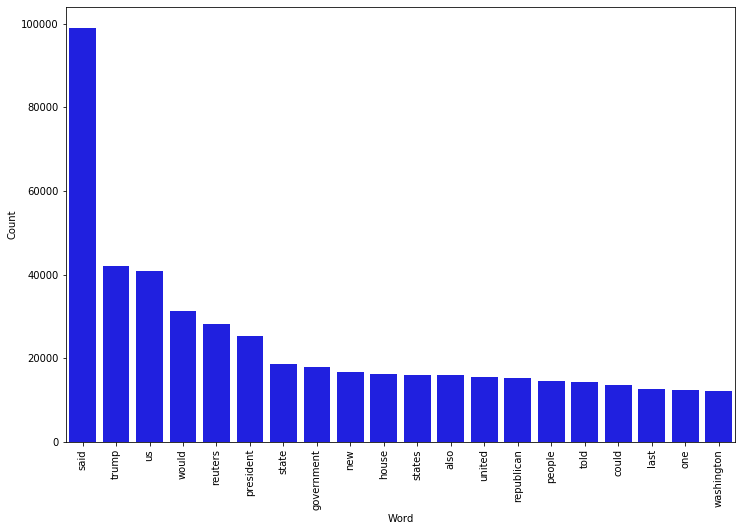

In [24]:
# Most frequent words in real news
counter(data[data["target"] == "true"], "text", 20)

In [25]:
#Modeling 

In [26]:

# Function to plot the confusion matrix (code from https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html)
from sklearn import metrics
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [27]:
#Peparing the data :

In [28]:
# Split the data
X_train,X_test,y_train,y_test = train_test_split(data['text'], data.target, test_size=0.2, random_state=42)

In [29]:
#Naive Bayes 

In [30]:
dct = dict()

from sklearn.naive_bayes import MultinomialNB

NB_classifier = MultinomialNB()
pipe = Pipeline([('vect', CountVectorizer()),
                 ('tfidf', TfidfTransformer()),
                 ('model', NB_classifier)])

model = pipe.fit(X_train, y_train)
prediction = model.predict(X_test)
print("accuracy: {}%".format(round(accuracy_score(y_test, prediction)*100,2)))

dct['Naive Bayes'] = round(accuracy_score(y_test, prediction)*100,2)

accuracy: 95.39%


Confusion matrix, without normalization


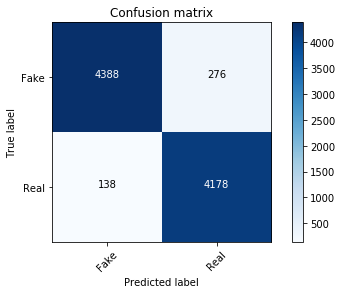

In [31]:
cm = metrics.confusion_matrix(y_test, prediction)
plot_confusion_matrix(cm, classes=['Fake', 'Real'])

In [32]:
#Logistic regression 

In [33]:
# Vectorizing and applying TF-IDF
from sklearn.linear_model import LogisticRegression

pipe = Pipeline([('vect', CountVectorizer()),
                 ('tfidf', TfidfTransformer()),
                 ('model', LogisticRegression())])

# Fitting the model
model = pipe.fit(X_train, y_train)

# Accuracy
prediction = model.predict(X_test)
print("accuracy: {}%".format(round(accuracy_score(y_test, prediction)*100,2)))
dct['Logistic Regression'] = round(accuracy_score(y_test, prediction)*100,2)

accuracy: 98.86%


Confusion matrix, without normalization


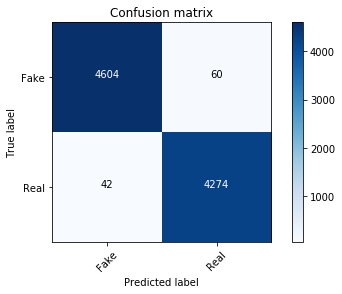

In [34]:
cm = metrics.confusion_matrix(y_test, prediction)
plot_confusion_matrix(cm, classes=['Fake', 'Real'])

In [35]:
#Decision Tree 

In [36]:

from sklearn.tree import DecisionTreeClassifier

# Vectorizing and applying TF-IDF
pipe = Pipeline([('vect', CountVectorizer()),
                 ('tfidf', TfidfTransformer()),
                 ('model', DecisionTreeClassifier(criterion= 'entropy',
                                           max_depth = 20, 
                                           splitter='best', 
                                           random_state=42))])
# Fitting the model
model = pipe.fit(X_train, y_train)

# Accuracy
prediction = model.predict(X_test)
print("accuracy: {}%".format(round(accuracy_score(y_test, prediction)*100,2)))
dct['Decision Tree'] = round(accuracy_score(y_test, prediction)*100,2)

accuracy: 99.58%


Confusion matrix, without normalization


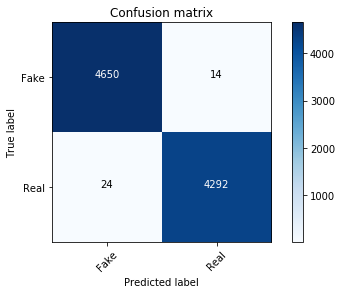

In [37]:
cm = metrics.confusion_matrix(y_test, prediction)
plot_confusion_matrix(cm, classes=['Fake', 'Real'])

In [38]:
#Random Forest 

In [39]:
from sklearn.ensemble import RandomForestClassifier

pipe = Pipeline([('vect', CountVectorizer()),
                 ('tfidf', TfidfTransformer()),
                 ('model', RandomForestClassifier(n_estimators=50, criterion="entropy"))])

model = pipe.fit(X_train, y_train)
prediction = model.predict(X_test)
print("accuracy: {}%".format(round(accuracy_score(y_test, prediction)*100,2)))
dct['Random Forest'] = round(accuracy_score(y_test, prediction)*100,2)

accuracy: 98.85%


Confusion matrix, without normalization


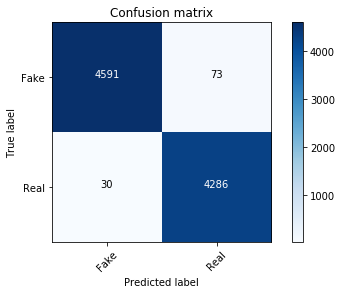

In [40]:

cm = metrics.confusion_matrix(y_test, prediction)
plot_confusion_matrix(cm, classes=['Fake', 'Real'])

In [41]:
#SVM

In [42]:
from sklearn import svm

#Create a svm Classifier
clf = svm.SVC(kernel='linear') # Linear Kernel

pipe = Pipeline([('vect', CountVectorizer()),
                 ('tfidf', TfidfTransformer()),
                 ('model', clf)])

model = pipe.fit(X_train, y_train)
prediction = model.predict(X_test)
print("accuracy: {}%".format(round(accuracy_score(y_test, prediction)*100,2)))
dct['SVM'] = round(accuracy_score(y_test, prediction)*100,2)

accuracy: 99.52%


In [43]:
from sklearn import svm

#Create a svm Classifier
clf = svm.SVC(kernel='linear') # Linear Kernel

pipe = Pipeline([('vect', CountVectorizer()),
                 ('tfidf', TfidfTransformer()),
                 ('model', clf)])

model = pipe.fit(X_train, y_train)
prediction = model.predict(X_test)
print("accuracy: {}%".format(round(accuracy_score(y_test, prediction)*100,2)))
dct['SVM'] = round(accuracy_score(y_test, prediction)*100,2)

accuracy: 99.52%


Confusion matrix, without normalization


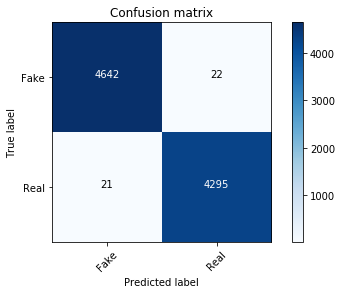

In [44]:
cm = metrics.confusion_matrix(y_test, prediction)
plot_confusion_matrix(cm, classes=['Fake', 'Real'])

In [45]:
#Comparing Different Models¶ 

([<matplotlib.axis.YTick at 0x7fbd10029410>,
 <a list of 10 Text yticklabel objects>)

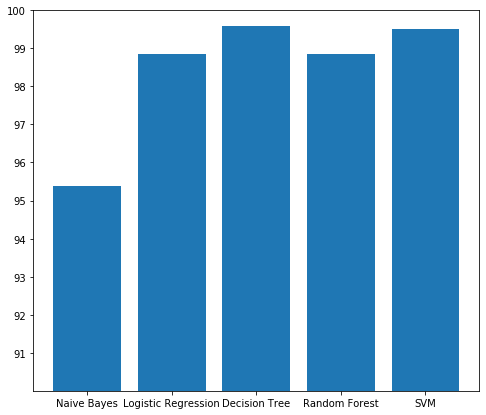

In [46]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8,7))
plt.bar(list(dct.keys()),list(dct.values()))
plt.ylim(90,100)
plt.yticks((91, 92, 93, 94, 95, 96, 97, 98, 99, 100))